# Face Recognition Using Siamese Network

We will understand the siamese network by building the face recognition model. The objective of our network is to understand whether two faces are similar or dissimilar. We use AT & T's the Database of Faces which can be downloaded from here (https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html)

Once you have downloaded and extracted the archive, you can see the folders like s1, s2 up to s40 as shown here:

![title](Images/1.png)

Each of these folders has 10 different images of a single person taken from various angles. For an instance, let us open folder s1. As you can see, there are 10 different images of a single person:

![title](Images/2.png)

We will open and check folder s13,

![title](Images/3.png)

As we know that siamese networks require inputs as a pair along with the label, we have to create our data in such a way. So we will take two images randomly from the same folder and mark it as a genuine pair and we will take a single image from two different folders and mark them as an imposite pair. A sample data is shown in the below figure, as you can notice a genuine pair has images of the same person and imposite pair has images of a different person. 

![title](Images/5.png)

Once we have our data as pairs along with their labels, we train our siamese network. From the image pair, we feed one image to the network A and another image to the network B. The role of these two networks is only to extract the feature vectors. So, we use two convolution layers with relu activations for extracting the features. Once we have learned the feature, we feed the resultant feature vector from both of the networks to the energy function which measures the similarity,  we use Euclidean distance as our energy function. So, we train our network by feeding the image pair to learn the semantic similarity between them.  Now, we will see this step by step. 


First, we will import the required libraries.

In [1]:
import re
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

Using TensorFlow backend.


Now, we define a function for reading our input image. The function read_image takes input as an image and returns the numpy array.

In [2]:
def read_image(filename, byteorder='>'):
    
    #first we read the image, as a raw file to the buffer
    with open(filename, 'rb') as f:
        buffer = f.read()
    
    #using regex, we extract the header, width, height and maxval of the image
    header, width, height, maxval = re.search(
        b"(^P5\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    
    #then we convert the image to numpy array using np.frombuffer which interprets buffer as one dimensional array
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))



For an example, Let us open one image,

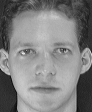

In [3]:
Image.open("data/orl_faces/s1/1.pgm")

When we feed this image to our read_image function, it will return as the numpy array,

In [4]:
img = read_image('data/orl_faces/s1/1.pgm')

In [5]:
img.shape

(112, 92)

Now, we define another function get_data for generating our data. As we know, for the Siamese network, data should be in the form of pairs (genuine and imposite) with a binary label.

First, we read the images (img1, img2) from the same directory and store them in the x_genuine_pair array and assign y_genuine to 1. Next, we read the images (img1, img2) from the different directory and store them in the x_imposite pair and assign y_imposite to 0.

Finally, we concatenate both x_genuine_pair, x_imposite to X and y_genuine, y_imposite to Y:

In [6]:
size = 2
total_sample_size = 10000


def get_data(size, total_sample_size):
    #read the image
    image = read_image('data/orl_faces/s' + str(1) + '/' + str(1) + '.pgm', 'rw+')
    #reduce the size
    image = image[::size, ::size]
    #get the new size
    dim1 = image.shape[0]
    dim2 = image.shape[1]

    count = 0
    
    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    x_geuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])  # 2 is for pairs
    y_genuine = np.zeros([total_sample_size, 1])
    
    for i in range(40):
        for j in range(int(total_sample_size/40)):
            ind1 = 0
            ind2 = 0
            
            #read images from same directory (genuine pair)
            while ind1 == ind2:
                ind1 = np.random.randint(10)
                ind2 = np.random.randint(10)
            
            # read the two images
            img1 = read_image('data/orl_faces/s' + str(i+1) + '/' + str(ind1 + 1) + '.pgm', 'rw+')
            img2 = read_image('data/orl_faces/s' + str(i+1) + '/' + str(ind2 + 1) + '.pgm', 'rw+')
            
            #reduce the size
            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]
            
            #store the images to the initialized numpy array
            x_geuine_pair[count, 0, 0, :, :] = img1
            x_geuine_pair[count, 1, 0, :, :] = img2
            
            #as we are drawing images from the same directory we assign label as 1. (genuine pair)
            y_genuine[count] = 1
            count += 1

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_imposite = np.zeros([total_sample_size, 1])
    
    for i in range(int(total_sample_size/10)):
        for j in range(10):
            
            #read images from different directory (imposite pair)
            while True:
                ind1 = np.random.randint(40)
                ind2 = np.random.randint(40)
                if ind1 != ind2:
                    break
                    
            img1 = read_image('data/orl_faces/s' + str(ind1+1) + '/' + str(j + 1) + '.pgm', 'rw+')
            img2 = read_image('data/orl_faces/s' + str(ind2+1) + '/' + str(j + 1) + '.pgm', 'rw+')

            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]

            x_imposite_pair[count, 0, 0, :, :] = img1
            x_imposite_pair[count, 1, 0, :, :] = img2
            #as we are drawing images from the different directory we assign label as 0. (imposite pair)
            y_imposite[count] = 0
            count += 1
            
    #now, concatenate, genuine pairs and imposite pair to get the whole data
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y

Now, we generate our data and check our data size. As you can see we have 20,000 data points, out of these 10,000 are genuine pairs and 10,000 are imposite pairs. 

In [7]:
X, Y = get_data(size, total_sample_size)

In [8]:
X.shape

(20000, 2, 1, 56, 46)

In [9]:
Y.shape

(20000, 1)

Next, we split our data for training and testing with 75% training and 25% testing proportions:

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.25)

Now that, we have successfully generated our data, we build our siamese network. First, we define the base network which is basically a convolutional network used for feature extraction. We build two convolutional layers with rectified linear unit (ReLU) activations and max pooling followed by flat layer.

In [11]:
def build_base_network(input_shape):
    
    seq = Sequential()
    
    nb_filter = [6, 12]
    kernel_size = 3
    
    
    #convolutional layer 1
    seq.add(Convolution2D(nb_filter[0], kernel_size, kernel_size, input_shape=input_shape,
                          border_mode='valid', dim_ordering='th'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))  
    seq.add(Dropout(.25))
    
    #convolutional layer 2
    seq.add(Convolution2D(nb_filter[1], kernel_size, kernel_size, border_mode='valid', dim_ordering='th'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='th')) 
    seq.add(Dropout(.25))

    #flatten 
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    return seq


Next, we feed the image pair, to the base network, which will return the embeddings that is, feature vectors:

In [12]:
input_dim = x_train.shape[2:]
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

In [13]:
base_network = build_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

These feat_vecs_a and feat_vecs_b are the feature vectors of our image pair. Next, we feed this feature vectors to the energy function to compute the distance between them, we use Euclidean distance as our energy function.

In [14]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [15]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

 Now, we set the epoch length to 13 and we use RMS prop for optimization and define our model.

In [16]:
epochs = 13
rms = RMSprop()

In [17]:
model = Model(input=[img_a, img_b], output=distance)

Next, we define our loss function as contrastive_loss function and compile the model. 

In [18]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [19]:
model.compile(loss=contrastive_loss, optimizer=rms)

In [20]:
img_1 = x_train[:, 0]
img2 = x_train[:, 1]

In [21]:
model.fit([img_1, img2], y_train, validation_split=.25,
          batch_size=128, verbose=2, nb_epoch=epochs)

Train on 11250 samples, validate on 3750 samples
Epoch 1/13
 - 60s - loss: 0.2179 - val_loss: 0.2156
Epoch 2/13
 - 53s - loss: 0.1520 - val_loss: 0.2102
Epoch 3/13
 - 53s - loss: 0.1190 - val_loss: 0.1545
Epoch 4/13
 - 55s - loss: 0.0959 - val_loss: 0.1705
Epoch 5/13
 - 52s - loss: 0.0801 - val_loss: 0.1181
Epoch 6/13
 - 52s - loss: 0.0684 - val_loss: 0.0821
Epoch 7/13
 - 52s - loss: 0.0591 - val_loss: 0.0762
Epoch 8/13
 - 52s - loss: 0.0526 - val_loss: 0.0655
Epoch 9/13
 - 52s - loss: 0.0475 - val_loss: 0.0662
Epoch 10/13
 - 52s - loss: 0.0444 - val_loss: 0.0469
Epoch 11/13
 - 52s - loss: 0.0408 - val_loss: 0.0478
Epoch 12/13
 - 52s - loss: 0.0381 - val_loss: 0.0498
Epoch 13/13
 - 54s - loss: 0.0356 - val_loss: 0.0363


Now, we make predictions with test data

In [22]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])

In [23]:
def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.5].mean()

Finally, we check our model accuracy. 

In [24]:
compute_accuracy(pred, y_test)

0.9258126195028681